In [1]:
import numpy as np 
import math
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

from numba import jit,njit, prange


In [2]:
sigma   = 1
L =  100
npart = 32
pressure = 1
dL_max = 0.05
dx = 1.0/16
halfL = L/2

#z=1 #exp(mu)

In [3]:
# Some helper functions
@jit
def wrap(particle):
    '''Apply perodic boundary conditions.'''
    if particle >= L:
        particle -= L
    elif particle < 0:
        particle += L
    return particle

In [4]:
@jit
def Vext_cal(x,a,b,c):
    V=0
    return V    

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


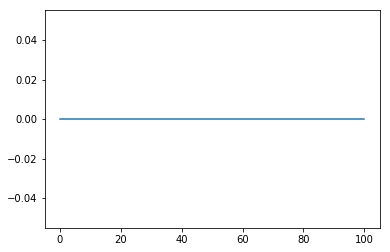

In [5]:
x= np.linspace(0,L,32//dx)
Vext = np.zeros(int(32/dx))
for i in range (int(32/dx)):
    Vext[i]=Vext_cal(i*L/32*dx,1,L/4,3)
plt.plot(x,Vext)


In [6]:
@jit
def distancesq(x1, x2,L):
    '''Gets the squared distance between two particles, applying the minimum image convention.'''
    # Calculate distances
    Dx = np.abs(x1-x2)
    if Dx > L/2:
        Dx -= L
    return Dx**2

In [7]:
@jit
def energy(particles,epsilon,a,b,c,L):
    '''Gets the energy of the system'''
    energy = 0.
    
    for i in range(npart):
        for j in range(npart):
            if(i!=j):
                dist = distancesq(particles[i], particles[j],L)
                if(dist**0.5<16):
                    energy += 4.*epsilon*((1/dist**6)-(1/dist**3))
                if(dist<1):
                    return 10**8
    energy/=2
    
    for i in range(npart):
        energy+=Vext_cal(particles[i],a,b,c)
    
    return energy 

In [8]:
@jit
def particleEnergy(particle,p,particles,epsilon,a,b,c,L):
    '''Gets the energy of a single particle.'''
    part_energy = 0.
    
    for i in range(npart):
        if(i!=p):
            dist = distancesq(particle, particles[i],L)
            if(dist**0.5<16):
                part_energy += 4*epsilon*((1/dist**6)-(1/dist**3))
            if(dist<1):
                return 10**8
    
    part_energy+=Vext_cal(particle,a,b,c)
    
    return part_energy

In [9]:
# Initialize the simulation box:
@jit
def initial(L):
    particles = np.zeros(npart)
    
    for i in range(npart):
        x_coord = np.random.uniform(0, L)
        particles[i]=i*L/npart
        #prop = random.uniform(0, 1)
        #if(prop>=0.5):
        #    exist[i]=1
    return particles

In [10]:
@jit
def MC_step(particles,L,pressure,steps,eps,a,b,c,Print=True):
    for step in range(0, steps):
        prop = np.random.uniform(0, 1)#volumn or move
        if (prop*(npart+1) + 1 < npart):
            for i in range(npart):
                # Move particle and evaluate energy
                this_particle = np.copy(particles[i])
                prev_E = particleEnergy(this_particle,i, particles, eps,a,b,c,L)
                this_particle =np.random.uniform(0, L)
                new_E =  particleEnergy(this_particle,i, particles, eps,a,b,c,L)
                deltaE = new_E - prev_E
                rand = np.random.uniform(0,1)
                #if(deltaE<10**3):
                if (np.exp(-deltaE) > rand):
                    particles[i] = this_particle
                
        else:
            oldL =  L
            rand = np.random.uniform(-0.5, 0.5)
            #Suggest a random volume by preforming a random walk in lnV.
            lnLTrial = np.log(oldL*(1+rand*dL_max)) 
            LTrial = np.exp(lnLTrial)
            newL = LTrial
            coordsTrial = particles*(newL/oldL)
            energy_old = energy(particles,eps,a,b,c,oldL)
            energy_new = energy(coordsTrial,eps,a,b,c,newL)
            weight=(energy_new - energy_old) + pressure*(newL - oldL) - (npart+1)*np.log(newL/oldL)
            
            rand = np.random.uniform(0, 1)
            #if(weight<10**3):
            if (rand < np.exp(-weight)):
                L = newL
                particles*=(newL/oldL)
                #if(L<npart):
                    #print(particles,L)
    return particles,energy(particles,eps,a,b,c,L),L

In [11]:
@jit
def MC_result(seed,L,pressure,eps,a,b,c):
    np.random.seed(seed)
    particles = initial(L)
    "warm up"
    particles, ene ,L= MC_step(particles,L,pressure,10**5,eps,a,b,c)
    print("WARM UP",ene,L)
    avg_step = 10**5
    ene_array = np.zeros(0)
    L_array = np.zeros(0)
    ene_array=np.append(ene_array,energy)
    L_array=np.append(L_array,L)
    for i in range(avg_step-1):
        np.random.seed(i)
        particles, ene,L = MC_step(particles,L,pressure,512,eps,a,b,c,Print=False)
        ene_array=np.append(ene_array,ene)
        L_array=np.append(L_array,L)
        #rho += density_cal(particles)

        #if(i%1000==0):
        #    print(i,ene,L)
    #rho=rho/avg_step
    #print("energy_avg",np.sum(ene_array)/len(ene_array),
    #      np.sum(L_array)/len(L_array))
    return particles,ene_array,L_array

@jit
def density_result(seed,L,pressure,eps):
    """
    density = random.uniform(0.3,0.5)
    a=random.uniform(1,3)
    b=random.uniform(0,1)
    c=random.uniform(1,L/8)
    """
    a=0
    b=0
    c=0
    particles,energy,L_array = MC_result(seed,L,pressure,eps,a,b,c)
    return particles,energy,L_array

In [12]:

def run(L):
    N=30
    P_array=np.exp(np.linspace(np.log(0.05),np.log(10),N))
    print(P_array)
    rho_array=np.zeros(N)
    phase=4
    eps = phase*0.5
    print("eps\t=\t",eps)
    file = "P_rho_eps_"+str(eps)+".dat"
    with open(file, "w") as text_file:
        for i in range (N):
            print(i,"/",N)
            particles,energy_array,L_array=density_result(123,L,P_array[i],eps)
            rho0=np.mean(npart/L_array)
            rho1=npart/np.mean(L_array)
            L=np.mean(L_array)
            text_file.write(str(P_array[i])+'\t'+str(rho0)+'\t'+str(rho1)+"\n")
            print(str(P_array[i])+'\t'+str(rho0)+'\t'+str(rho1)+"\n")
            if(rho0>0.85):
                break;

In [13]:
run(L)

[ 0.05        0.06002275  0.0720546   0.0864983   0.10383732  0.12465202
  0.14963913  0.17963503  0.21564376  0.25887062  0.31076251  0.37305639
  0.44783739  0.5376086   0.6453749   0.77474349  0.93004464  1.11647668
  1.34027994  1.60894568  1.93146678  2.31863883  2.78342143  3.341372
  4.01116651  4.81522464  5.78046019  6.93918197  8.33017525 10.        ]
eps	=	 2.0
0 / 30
WARM UP -8.52752584767193 573.1501164424631
0.05000000000000001	0.052995343884198444	0.05128092158111221

1 / 30
WARM UP -8.869924721336961 485.49706629617
0.060022746833882736	0.0637504247495234	0.06170664211021261

2 / 30
WARM UP -8.049694053849741 433.7654795905069
0.07205460274968759	0.0770611297126209	0.0744882516636627

3 / 30
WARM UP -5.184975688029545 345.24814742783235
0.08649830358120976	0.0930205088585923	0.08994108167649768

4 / 30
WARM UP -12.610179899238133 239.92698635624862
0.10383731554830569	0.11218127466598202	0.10847549690762198

5 / 30
WARM UP -11.828016551442378 224.39738275815031
0.124652